In [15]:
from numpy import genfromtxt
from PIL import Image, ImageDraw, ImageChops
import numpy as np
import cv2
import json
from matplotlib import pyplot as plt
from skimage.morphology import binary_opening, binary_closing,binary_erosion, rectangle, binary_dilation, disk
from skimage.segmentation import find_boundaries

# From Converted RJPEG To Temperature csv

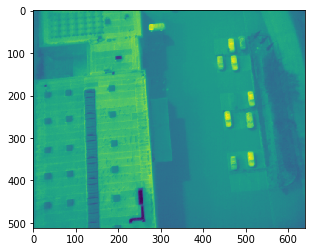

In [269]:
#thermal_tab = genfromtxt('/Users/stouzani/Desktop/Unstructured_ML/Drone/Drone_Data_Capture/Veracruz/Thermal_preproc/temperature_DJI_0490_door.csv', delimiter=',')
thermal_tab = genfromtxt('/Users/stouzani/Desktop/Unstructured_ML/Drone/Drone_Data_Capture/singapore/Thermal_preproc/IX-x1-00057_0278_0109_THM.csv', delimiter=',')

# thermal_tab = np.rot90(thermal_tab,3)
# exclude the bottom right column because of some noise
# thermal_tab = thermal_tab[0:147,0:485]
plt.figure()
plt.imshow(thermal_tab)

In [270]:
thermal_tab.shape

(512, 640)

In [271]:
np.amax(thermal_tab)

21.1874010429829

In [272]:
np.amin(thermal_tab)

-8.58709785285782

# Load mask json

In [273]:
mask_json = json.load(open('/Users/stouzani/Desktop/Unstructured_ML/Drone/Drone_Data_Capture/singapore/masks_thm/IX-x1-00057_0278_0109_THM_2.json'))

In [274]:
objects = mask_json.get("objects")[0]

In [275]:
points_lab = objects['points']

In [276]:
nested_lists = points_lab['exterior']

In [277]:
mask_polygon = [tuple(l) for l in nested_lists]

In [278]:
def getMask(original,polygon):
    #Returns the mask of the polygon
    mask = Image.new('L', (original.shape[1],original.shape[0]), 0)
    mask_draw = ImageDraw.Draw(mask)
    mask_draw.polygon(polygon, outline=1, fill=1)
    return np.array(mask, dtype=bool)

In [279]:
mask = getMask(thermal_tab,mask_polygon)

In [280]:
mask.shape

(512, 640)

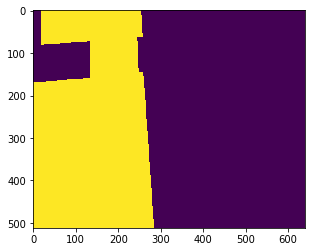

In [281]:
plt.figure()
plt.imshow(mask)

In [282]:
pixel_values = thermal_tab.reshape((-1, 1))
pixel_values = np.float32(pixel_values)
pixel_values.shape

(327680, 1)

In [283]:
mask_pixel_values = mask.reshape((-1, 1))
mask_pixel_values.shape

(327680, 1)

In [284]:
pixel_values_croped = pixel_values[mask_pixel_values].reshape((-1, 1))
pixel_values_croped.shape

(123182, 1)

In [285]:
pixel_values_croped

array([[ 7.021664],
       [ 8.094572],
       [ 7.730257],
       ...,
       [ 9.561086],
       [10.036779],
       [ 9.513379]], dtype=float32)

In [286]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)

In [287]:
# number of clusters (K)
k = 8
_, labels, (centers) = cv2.kmeans(pixel_values_croped, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

In [288]:
centers

array([[ 9.621153 ],
       [ 2.001957 ],
       [ 4.464115 ],
       [ 6.9867826],
       [12.685644 ],
       [ 8.456847 ],
       [11.040705 ],
       [-5.489799 ]], dtype=float32)

In [289]:
labels

array([[3],
       [5],
       [5],
       ...,
       [0],
       [0],
       [0]], dtype=int32)

In [290]:
# convert back to 8 bit values
centers = np.int8(centers)

# flatten the labels array
labels = labels.flatten()

In [291]:
centers

array([[ 9],
       [ 2],
       [ 4],
       [ 6],
       [12],
       [ 8],
       [11],
       [-5]], dtype=int8)

In [292]:
# convert all pixels to the color of the centroids
segmented_image_copped = centers[labels.flatten()]

In [293]:
segmented_image_copped.shape

(123182, 1)

In [294]:
segmented_image_copped.dtype

dtype('int8')

In [295]:
segmented_image = 20+np.zeros(pixel_values.shape, dtype=int)#pixel_values.astype(np.int8)

In [296]:
segmented_image

array([[20],
       [20],
       [20],
       ...,
       [20],
       [20],
       [20]])

In [297]:
segmented_image.shape

(327680, 1)

In [298]:
pixel_values.shape

(327680, 1)

In [299]:
segmented_image[mask_pixel_values] = segmented_image_copped[:,0]

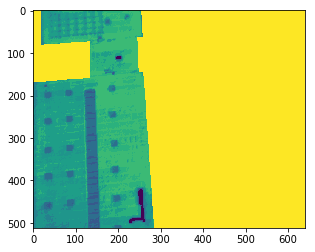

In [300]:
# reshape back to the original image dimension
segmented_image = segmented_image.reshape(thermal_tab.shape)
# show the image
plt.imshow(segmented_image)
plt.show()

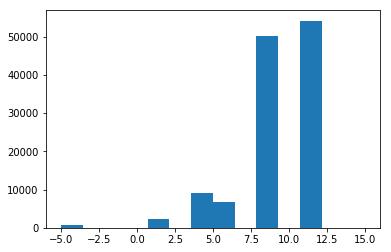

((array([  834.,     0.,     0.,     0.,  2233.,     0.,  9028.,  6700.,
             0., 50207.,     0., 54180.,     0.,     0.]),
  array([-5.        , -3.57142857, -2.14285714, -0.71428571,  0.71428571,
          2.14285714,  3.57142857,  5.        ,  6.42857143,  7.85714286,
          9.28571429, 10.71428571, 12.14285714, 13.57142857, 15.        ]),
  <a list of 14 Patch objects>),
 None)

In [306]:
from matplotlib import pyplot as plt

# x = np.random.randint(25,100,25)
# y = np.random.randint(175,255,25)
# z = np.hstack((x,y))
# z = z.reshape((50,1))
# z = np.float32(z)
plt.hist(segmented_image_copped,14,[-5,15]),plt.show()


In [302]:
segmented_image_f = np.float32(segmented_image)

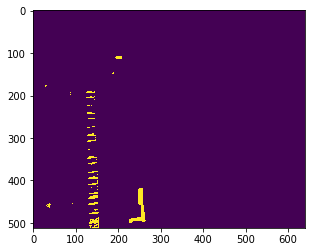

In [308]:
th = cv2.threshold(segmented_image_f,3,255,cv2.THRESH_BINARY)[1]
thresholded = th.astype(np.uint8)
thresholded = np.invert(thresholded)
plt.figure()
plt.imshow(thresholded)

In [309]:
thresholded = binary_dilation(thresholded, rectangle(1,5))

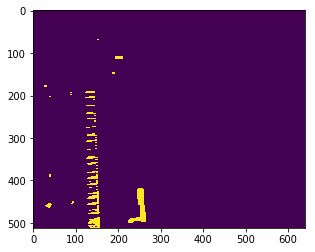

In [310]:
plt.figure()
plt.imshow(thresholded)

In [311]:
# thresholded = binary_erosion(thresholded, rectangle(5,1))
# plt.figure()
# plt.imshow(thresholded)

In [312]:
thresholded_2 = thresholded.astype(np.uint8)
contours, hierarchy = cv2.findContours(thresholded_2, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

### Create RGB images

In [313]:
thermal_im = 255*(thermal_tab - np.min(thermal_tab))/np.ptp(thermal_tab).astype(int)

In [314]:
thermal_im = cv2.cvtColor(thermal_im.astype(np.uint8),cv2.COLOR_GRAY2RGB)

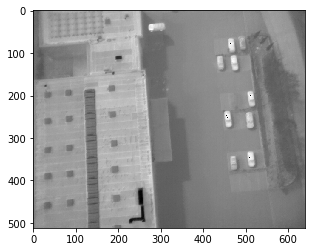

In [315]:
plt.figure()
plt.imshow(thermal_im)

In [316]:
mask = np.zeros(thermal_im.shape, np.uint8)
borders_im = cv2.drawContours(mask, contours, -1, (255,0,0),3)

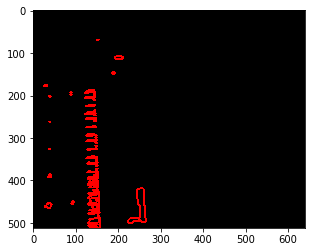

In [317]:
plt.figure()
plt.imshow(borders_im)

#### superimpose images


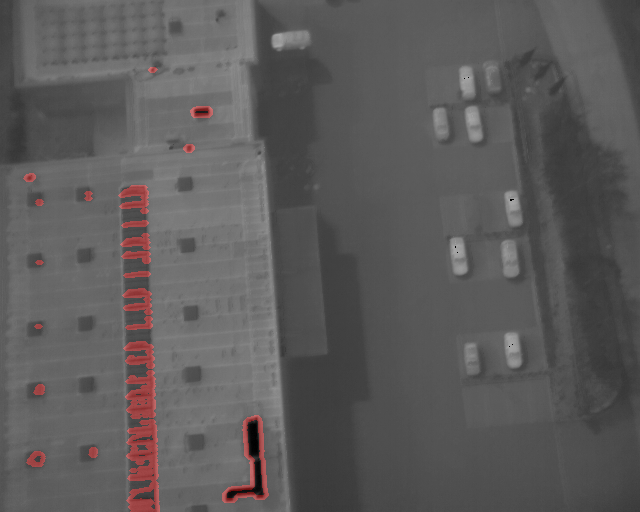

In [318]:
thermal_im_1 = Image.fromarray(thermal_im)
borders_im_1 = Image.fromarray(borders_im)
thermal_im_1 = thermal_im_1.convert("RGBA")
borders_im_1 = borders_im_1.convert("RGBA")
new_img = Image.blend(thermal_im_1, borders_im_1, 0.35)
new_img